In [1]:
import cPickle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pymbar import timeseries
from assaytools import pymcmodels
from assaytools.bindingmodels import TwoComponentBindingModel

# The functions this notebook will demonstrate
from assay_simulator import AssaySimulator, predict_assay_error

# Estimating optimal protein concentrations for p38-Bosutinib
### Demonstrating how `AssaySimulator` can be used to simulate fluorescence data

The `AssaySimulator` is a simple class that takes the output data from the `assaytools` PyMC modelling and is able to simulate fluorescence data for the same complex under different conditions, such as protein concentration. 

Loading the pymc MCMC parameter samples for `assaytools`.

In [2]:
data_file = 'p38-Bosutinib-AB_mcmc-2017-03-24 11:47.pickle'
with open(r'%s'%data_file,'rb') as my_file:
    data = cPickle.load(my_file)

#### Time series analysis to determine burn-in point.
Using the model's estimated free energy to identify the equilibrium point.

In [3]:
DeltaG_samples = data['DeltaG'][0]
(t_equil, g, N_eff) = timeseries.detectEquilibration(DeltaG_samples, fast=True, nskip=1)

# Seeing the mean of the free energy
mean_DeltaG = np.mean(DeltaG_samples[t_equil:])
print('Expected free energy = {0} (thermal units)'.format(mean_DeltaG))

Expected free energy = -12.8638611732 (thermal units)


## Plotting fluorescence for different protein concentrations
Example of using the class `AssaySimulator` to draw possible fluorescence data.

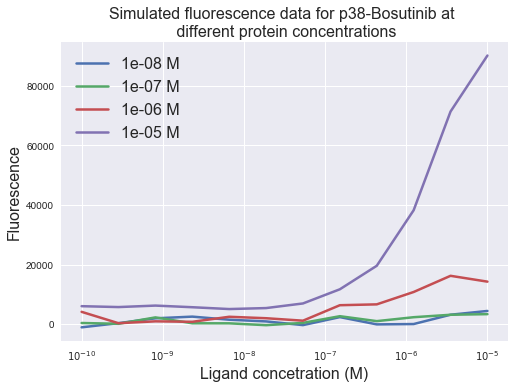

In [4]:
# Ligand and protein concentrations
L_total = 10 ** (np.linspace(-10, -5, num=12))
P_total = 1E-6

# Initialize the class using assaytools PyMC data:
sim_assay = AssaySimulator(pymc_data=data, l_total=L_total, inner_filter=True)

# By default, assaytools parameters are drawn from the posterior. Setting the parameters to their mean values:
sim_assay.set_mean_parameters(data, t_equil)

# Plotting fluorescence for protein concentrations using the mean assaytools parameters
for p in [10E-9, 10E-8, 10E-7, 10E-6, ]:
    F = sim_assay.simulate_fluorescence(p_total=p, noisy=True)
    plt.semilogx(L_total, F, label="{0} M".format(p), lw=2.5)

plt.title('Simulated fluorescence data for p38-Bosutinib at \n different protein concentrations', fontsize=16)
plt.xlabel('Ligand concetration (M)', fontsize=16)
plt.ylabel('Fluorescence', fontsize=16)
plt.legend(fontsize=16)
plt.show()

## Plotting fluorescence for different binding energies
### The inner filter effect is active

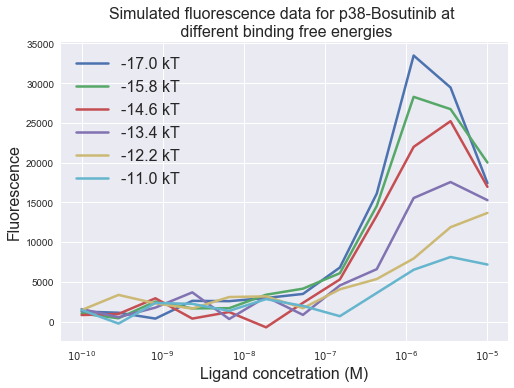

In [5]:
# Ligand and protein concentrations
L_total = 10 ** (np.linspace(-10, -5, num=12))
P_total = 1E-6

# Initialize the class
sim_assay = AssaySimulator(pymc_data=data, l_total=L_total, inner_filter=True)
sim_assay.set_mean_parameters(data, t_equil)

# Plotting fluorescence for binding energies using the mean assaytools parameters
for g in np.linspace(-17,-11,6):
    F = sim_assay.simulate_fluorescence(DeltaG=g, noisy=True)
    plt.semilogx(L_total, F, label="{0} kT".format(g), lw=2.5)

plt.title('Simulated fluorescence data for p38-Bosutinib at \n different binding free energies', fontsize=16)
plt.xlabel('Ligand concetration (M)', fontsize=16)
plt.ylabel('Fluorescence', fontsize=16)
plt.legend(fontsize=16)                             
plt.show()

### The inner filter effect is inactive

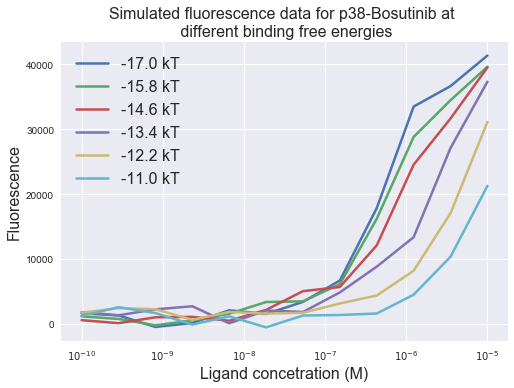

In [6]:
# Ligand and protein concentrations
L_total = 10 ** (np.linspace(-10, -5, num=12))
P_total = 1E-6

# Initialize the class without the inner filter effect
sim_assay = AssaySimulator(pymc_data=data, l_total=L_total, inner_filter=False)
sim_assay.set_mean_parameters(data, t_equil)

# Plotting fluorescence for binding energies using the mean assaytools parameters
for g in np.linspace(-17,-11,6):
    F = sim_assay.simulate_fluorescence(DeltaG=g, noisy=True)
    plt.semilogx(L_total, F, label="{0} kT".format(g), lw=2.5)

plt.title('Simulated fluorescence data for p38-Bosutinib at \n different binding free energies', fontsize=16)
plt.xlabel('Ligand concetration (M)', fontsize=16)
plt.ylabel('Fluorescence', fontsize=16)
plt.legend(fontsize=16)                             
plt.show()

## Generating error distributions for fixed assay conditions
For given set of assay paramters, one can estimate the error distribution of the fitted $\Delta G$s upon may repeats of a fluorescence experiment with the function `generate_deltag_estimates()`. Given fixed parameters, `generate_deltag_estimates()` will draw multiple sets of fluorescence titration data, each with different amounts of random noise added. For each draw, the binding free energy is estimated using least squares regression.  

In [7]:
# The ligand and protein concentrations used:
L_total = 10 ** (np.linspace(-10, -5, num=12))
P_total = 1E-6

# Initializing the AssaySimulator:
sim_assay = AssaySimulator(pymc_data=data, l_total=L_total, p_total=P_total, inner_filter=False)

# Setting the mean values of the parameters:
sim_assay.set_mean_parameters(pymc_data=data, t_equil=t_equil)

# Generate fitted binding free energies by least-squares fitting
estimates = sim_assay.generate_deltag_estimates(nsamples=1000)

Plotting the estimates spread of the estimates:

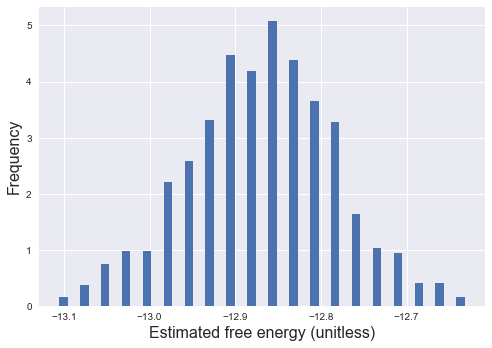

In [8]:
hist, edges = np.histogram(estimates, bins=20, normed=True)
centers = edges[0:-1] + np.diff(edges) / 2.0

plt.bar(centers, hist, width=0.01)
plt.xlabel('Estimated free energy (unitless)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In the next cell, I'll generate the estimate distributions for different protein concentrations.

In [9]:
nsamples = 3000
protein_concentrations = np.array([0.5E-6, 1E-6, 5E-6])
estimates = np.zeros((len(protein_concentrations), nsamples))

for i in range(len(protein_concentrations)):
    sim_assay = AssaySimulator(pymc_data=data, l_total=L_total, p_total=protein_concentrations[i], inner_filter=False)
    sim_assay.set_mean_parameters(pymc_data=data, t_equil=t_equil)
    estimates[i,:] = sim_assay.generate_deltag_estimates(nsamples)

Here's an example plot of the estimated posterior densities when the assay is performated at different protein concentrations.

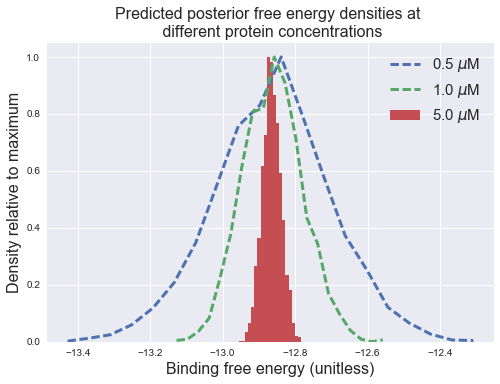

In [10]:
import seaborn as sns
cols = sns.color_palette("deep", 3)

for i in range(len(protein_concentrations)):
    hist, edges = np.histogram(estimates[i,:], bins=20, normed=True)
    hist = hist/hist.max()
    centers = edges[0:-1] + np.diff(edges) / 2.0
    if i !=2:
        plt.plot(centers, hist, lw=3, ls='--', color=cols[i], label="{} $\mu$M".format(protein_concentrations[i]*1.0E6))
    else:   
        plt.bar(centers, hist, width=0.01, color=cols[i], label="{} $\mu$M".format(protein_concentrations[i]*1.0E6))

plt.legend(fontsize=15)
plt.title('Predicted posterior free energy density at \n different protein concentrations', fontsize=16)
plt.xlabel('Binding free energy (unitless)', fontsize=16)
plt.ylabel('Density relative to maximum', fontsize=16)
plt.show()

In the above, each distribution has been scaled to it's maximum value.

## Varying the protein concentration to minimize the coefficient of variation

The above example explores how different protein concentrations affects the distribution of free energy estimates. In this next section, a more systematic approach is taken to finding the protein cocenctration produces the most consistent concentrations.

For a given protein concentration, parameter samples will be drawn from the posterior, fluorenscence data will be simulated, and the affinity estimated via least squares minimization. 

In [12]:
# The ligand concentrations used in the assay
L_total = 10 ** (np.linspace(-10, -5, num=12))

# The protein concentrations over which the coefficient of variation will be estimated
P_totals =10 ** (np.linspace(-10, -1, num=20))

# Number of times the fitting procedure will occur
nposterior_samples = 50  # The number of parameter draws from the posterior
nsamples = 50              # The number of repeated fluorescence draws for each posterior sample

# Predict the coeffecient of variation, variance and bias for the ligand and protein concentrations 
(CV, Var, Bias2) = predict_assay_error(data, L_total, P_totals, nsamples, nposterior_samples, t_equil=t_equil, inner_filter=True, geometry='top')

### Plotting data the coefficient of variation as function of protein concentration

The coefficient of variation (CV) is relative standard deviation of the estimated free energy, and is given by

$$ CV = \frac{\sigma_{\Delta G}}{|\Delta G|} $$

where $\sigma_{\Delta G}$ is the standard deviation. Below plots how this varies with protein concentration.

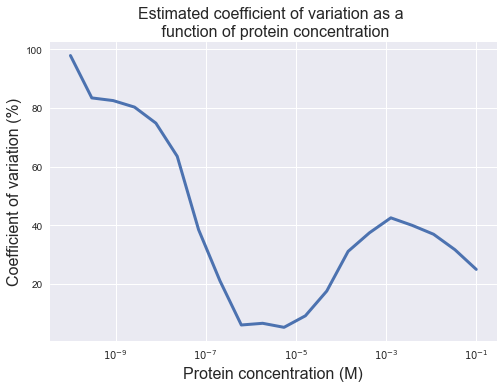

In [13]:
plt.semilogx(P_totals, CV, lw=3) 
plt.title('Estimated coefficient of variation as a \n function of protein concentration', fontsize=16)
plt.xlabel('Protein concentration (M)', fontsize=16)
plt.ylabel('Coefficient of variation (%)', fontsize=16)
plt.show()

This suggest that lowest variance in the estimates will occur at roughly 1$\mu$M of protein. Another measure of predictive accuracy is the total error, where 

$$ \text{Total Error}(\Delta G) = \text{Bias}(\Delta G)^2 + \text{Variance}(\Delta G) $$

and find which protein concentration minimizes this quantity.

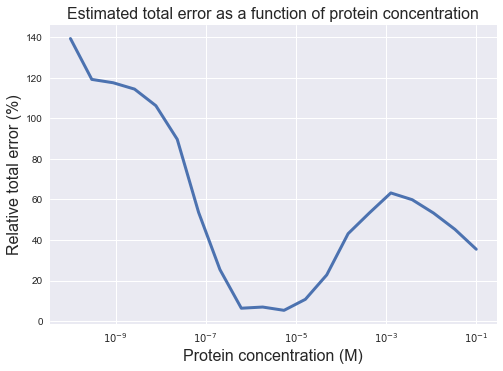

In [14]:
relative_total_error = np.sqrt(Bias2 + Var)/np.abs(mean_DeltaG)
plt.semilogx(P_totals, relative_total_error * 100, lw=3) 
plt.title('Estimated total error as a function of protein concentration', fontsize=16)
plt.xlabel('Protein concentration (M)', fontsize=16)
plt.ylabel('Relative total error (%)', fontsize=16)
plt.show()

This suggests the protein concentration that produces free energies with the lowest variance is around 1$\mu$M. This is more reasonable that what was suggested for the coefficient of variation.